In [1]:
import os
import os.path
import torch

import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

from time import time
from PIL import ImageFile

from csfnst.fastneuralstyle.networks import CustomTransformerNetInterpolateLarge
from csfnst.utils import load_image, plot_image_tensor, save_image_tensor

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
force_cpu = True
device = torch.device('cuda' if torch.cuda.is_available() and not force_cpu else 'cpu')
checkpoint_path = '../checkpoints/dali__c512_s1024__c1_s1e7_tv0.pth'
input_image_path = '../images/content/hidden/debby.jpg'
output_image_path = f'../images/output/{os.path.basename(checkpoint_path).split("__")[0]}_{os.path.basename(input_image_path)}'
input_image = load_image(input_image_path)

print(output_image_path)

../images/output/dali_debby.jpg


In [3]:
%%capture
if force_cpu:
    checkpoint = torch.load(checkpoint_path, map_location={'cuda:0': 'cpu'})
else:
    checkpoint = torch.load(checkpoint_path)
    
model = CustomTransformerNetInterpolateLarge()
model.load_state_dict(checkpoint['network_state_dict'])
model.eval()

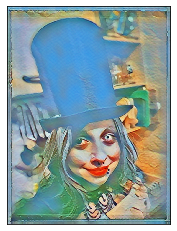

In [4]:
start = time()
output_image = model(input_image.unsqueeze(0)).squeeze()
end = time()

ouput_image = output_image.squeeze()

plot_image_tensor(output_image)
save_image_tensor(ouput_image, output_image_path)